In [1]:
import pandas as pd
import numpy as np
import torch as pt
from scipy.linalg import qr
import matplotlib.pyplot as plt
%matplotlib inline

from ml_lib.clusters.root_cluster import RootCluster as Root
from ml_lib.clusters.data_cluster import DataCluster as Data
from ml_lib.clusters.dense_cluster import DenseCluster as Dense
from ml_lib.controllers.controller import Controller as Control

from ml_lib.utils import *

#pt.set_default_tensor_type('torch.FloatTensor')
pt.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
class ConvolutionCluster(Root):
    def __init__(self, cluster_name, kernel_size, stride,
                 weight_init = inits.Normal, weight_init_params = {'mean': 0, 'stdev': 1},
                 bias_init = inits.Constant, bias_init_params = {'constant': 0},
                 combiner = combiners.Simple, combiner_params = {},
                 activator = activators.Linear, activator_params = {},
                 learner = learners.Gradient, learner_params = {}
                ):
        super().__init__(cluster_name)
        
        self.kernel_size = kernel_size
        self.stride = stride
        self.Inits = {
            'weights': weight_init(**weight_init_params),
            'bias': bias_init(**bias_init_params)
        }
        self.Combiner = combiner(**combiner_params)
        self.Activator = activator(**activator_params)
        self.Learner = learner(**learner_params)
        self.coefs = None
        
    def init_cluster(self, reinit = False, overwrite = False):
        super().init_cluster(reinit = reinit)
        self._init_coefs(overwrite)
        
    def _init_coefs(self, overwrite):
        if (self.coefs is not None) & (not overwrite):
            raise Exception('%s: Attempting to overwrite existing coefficents when overwrite is False' % self.name)
        
        init_coefs = {
            'weights': self.Inits['weights'].init((np.prod(self.kernel_size), self.get_input_count())),
            'bias': self.Inits['bias'].init((1, self.nodes))
        }
        self.coefs = init_coefs
        self.best_coefs = copy(self.coefs)
        
    def deinit_cluster(self):
        self._deinit_coefs()
        
    def _deinit_coefs(self):
        self.coefs = copy(self.best_coefs)

In [3]:
dataset = pd.get_dummies(pd.read_csv('data_files/mnist_train.csv'), columns = ['label'])
test_dataset = pd.read_csv('data_files/mnist_test.csv')

In [4]:
feature_cols = [col for col in dataset.columns if col.startswith('pixel')]
target_cols = [col for col in dataset.columns if col.startswith('label_')]

learner = learners.ADAM
learn_params = {
    'learn_rate': 1e-1,
    'scale_features': True
}

init = inits.Orthogonal
init_params = {
    'xavier': True
}

activator = activators.ReLU
activator_params = {}

control = Control(valid_split = 'valid')
control.add_cluster(
    Data(
        'data_cluster',
        dataset[feature_cols + target_cols],
        splitter = splitters.Validation, splitter_params = {},
        loss = losses.LogLoss, loss_params = {}
    )
)
control.add_link(
    Dense(
        'reg_cluster_1',
        512,
        weight_init = init, weight_init_params = init_params,
        activator = activator, activator_params = activator_params,
        learner = learner, learner_params = learn_params
    ),
    'data_cluster', 'input', data_cols = feature_cols
)
control.add_link(
    Dense(
        'reg_cluster_2',
        128,
        weight_init = init, weight_init_params = init_params,
        activator = activator, activator_params = activator_params,
        learner = learner, learner_params = learn_params
    ),
    'reg_cluster_1', 'input'
)
control.add_link(
    Dense(
        'reg_cluster_3',
        32,
        weight_init = init, weight_init_params = init_params,
        activator = activator, activator_params = activator_params,
        learner = learner, learner_params = learn_params
    ),
    'reg_cluster_2', 'input'
)
control.add_link(
    Dense(
        'reg_cluster_out',
        len(target_cols),
        weight_init = init, weight_init_params = init_params,
        activator = activators.SoftMax, activator_params = {},
        learner = learner, learner_params = learn_params
    ),
    'reg_cluster_3', 'input'
)
control.link_clusters('reg_cluster_out', 'data_cluster', data_cols = target_cols)
control.init_clusters()

In [5]:
control.train_model(1000)
control.deinit_clusters()

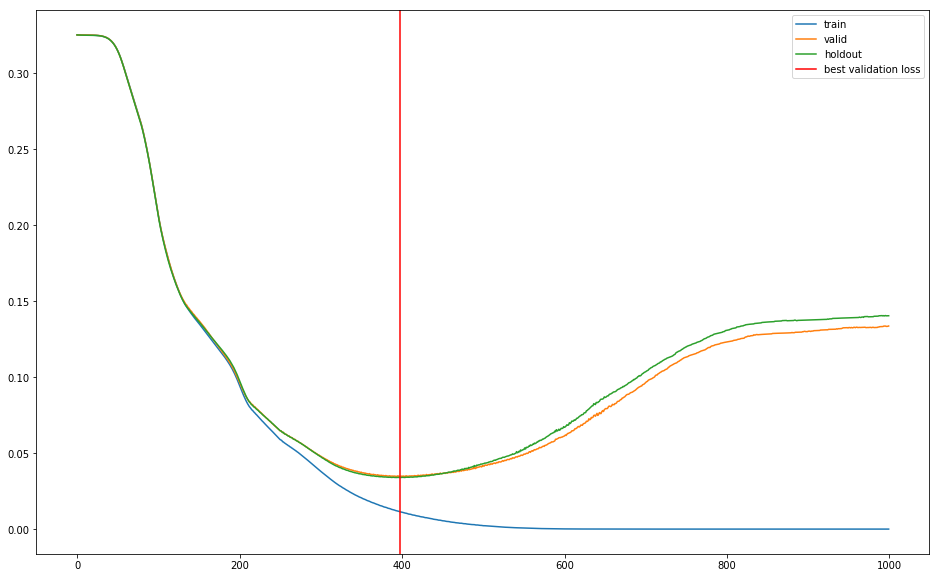

In [6]:
control.plot_losses()

In [7]:
outputs = control.get_outputs(data_override = {'data_cluster': test_dataset})

In [8]:
pd.DataFrame(outputs['reg_cluster_out'], index = test_dataset.index, columns = target_cols).idxmax(axis = 1).apply(lambda x: x.replace('label_', '')).to_csv('predict.csv')